# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# !pip install subword-nmt nltk torchtext
# !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

In [2]:
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
from IPython.display import clear_output
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu
from torchtext.data import Field, BucketIterator

import my_network

matplotlib.rcParams.update(
    {'figure.figsize': (16, 12), 'font.size': 14}
)

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [7]:
w = WordPunctTokenizer()
def tokenize(x, tokenizer=w):
     return tokenizer.tokenize(x.lower())

In [9]:
SRC = Field(
    tokenize=tokenize,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True
)

TRG = Field(
    tokenize=tokenize,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True
)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=(('trg', TRG), ('src', SRC))
)

In [10]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [11]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [12]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [13]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9267
Unique tokens in target (en) vocabulary: 6725


Here are tokens from original (RU) corpus:

In [14]:
SRC.vocab.itos[::1000]

['<unk>',
 'закусок',
 'hi',
 'книги',
 'atlantic',
 'a22',
 'portland',
 'фермерских',
 'длиной',
 'тао']

And from target (EN) corpus:

In [15]:
TRG.vocab.itos[::1000]

['<unk>', 'cars', 'diego', 'candolim', 'nairobi', 'speedboat', 'manoir']

And here is example from train dataset:

In [16]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'nearest', 'airport', 'is', 'anapa', 'airport', ',', '55', 'km', 'from', 'the', 'property', '.'], 'src': ['расстояние', 'до', 'аэропорта', 'анапы', 'составляет', '55', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


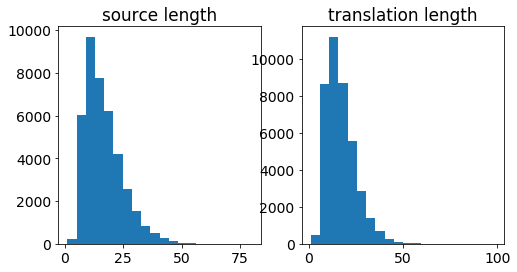

In [17]:
src_length = map(lambda x: len(x.src), train_data.examples)
trg_length = map(lambda x: len(x.trg), train_data.examples)

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(np.fromiter(src_length, dtype=int), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(np.fromiter(trg_length, dtype=int), bins=20);

Length distribution in Test data


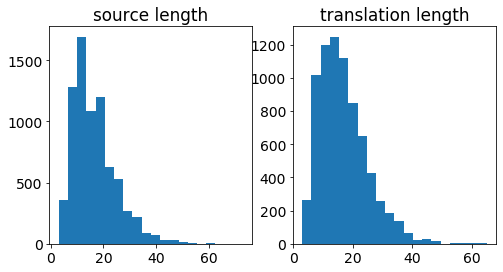

In [18]:
src_length = map(lambda x: len(x.src), test_data.examples)
trg_length = map(lambda x: len(x.trg), test_data.examples)

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(np.fromiter(src_length, dtype=int), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(np.fromiter(trg_length, dtype=int), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [20]:
device

device(type='cuda', index=0)

In [21]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key
)

In [22]:
iter(train_iterator)
x = next(iter(train_iterator))
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 53x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 49x128 (GPU 0)]
torch.Size([49, 128]) torch.Size([53, 128])


In [23]:
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [24]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [25]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (re_embedding): Linear(in_features=512, out_features=512, bias=True)
      (softmax): Softmax(dim=0)
    )
    (embedding): Embedding(6725, 256)
    (rnn): LSTM(768, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=1792, out_features=6725, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,819,525 trainable parameters


In [27]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [28]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
train_history = []
valid_history = []

N_EPOCHS = 18
CLIP = 1

best_valid_loss = float('inf')
best_bleau = 0

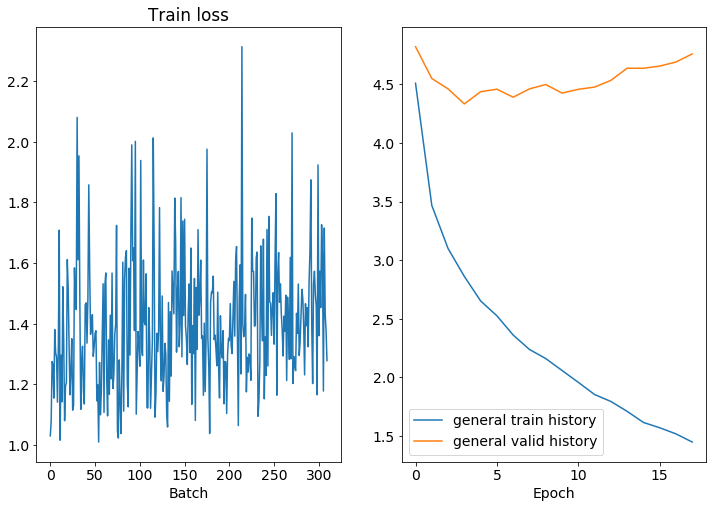

In [32]:
import utils
import imp

imp.reload(utils)

generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model-seq2seq.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

torch.save(model.state_dict(), 'tut1-model-seq2seq-last.pt')

__Let's take a look at our network quality__:

In [34]:
from importlib import reload

import utils

reload(utils)

generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [35]:
def generate_translation(src, trg, model, TRG_vocab, BPE = False):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = [TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]
    generated = [TRG_vocab.itos[x] for x in list(output[:, 0])]
    
    original = remove_tech_tokens(original)
    generated = remove_tech_tokens(generated)[1:]
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [36]:
batch = next(iter(test_iterator))

In [37]:
for idx in (1, 2):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: a front desk is at your service for 24 hours .
Generated: there is a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .



In [41]:
original_text = []
generated_text = []

model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab)[1:] for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 18.95it/s]


In [42]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

25.114489213133528

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

## Вывод

Как видим, простейший подход с использованием `attention` может давать приемлемые результаты.

Были опробованы следующие два подхода:
1. К имеющимся корпусам были применены BPE-токенайзеры, обученные на всех статьях русской и английской Википедий соответсвенно. Преобразованные таким образом тексты были поданы на вход модели из данного ноутбука. К сожалению, это преобразование ухудшило результаты:
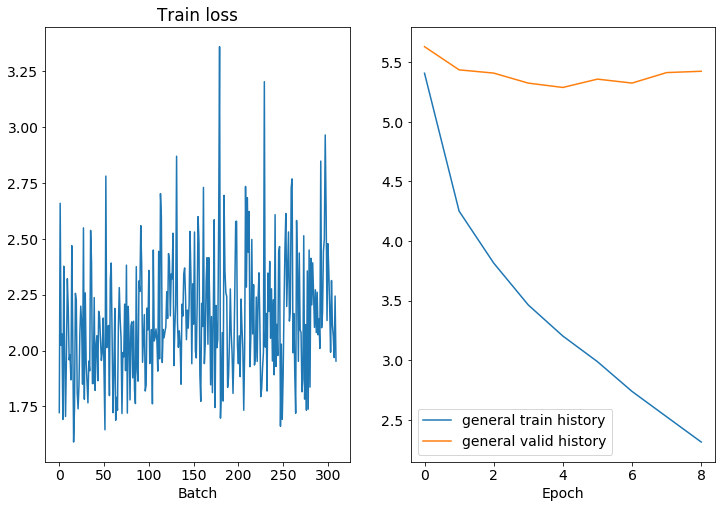
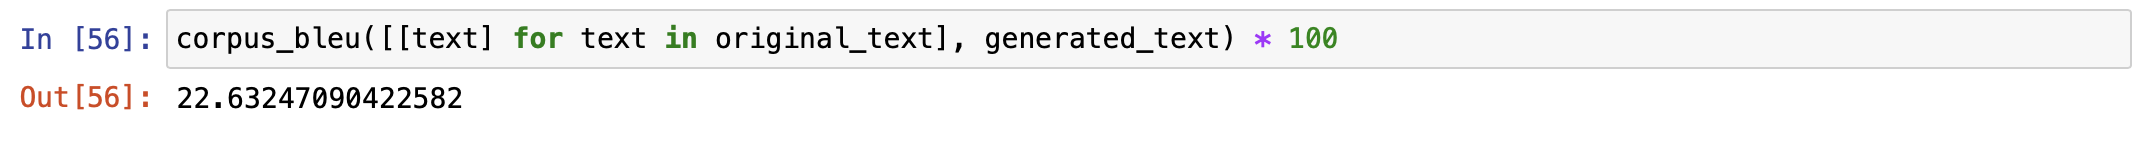
2. Вместо текущей модели был имплементирован трансформер, но с определённого батча он вообще отказался обучаться.
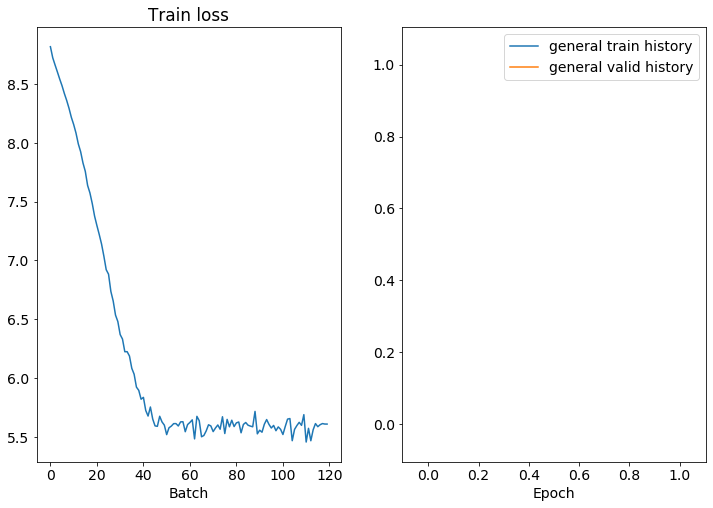
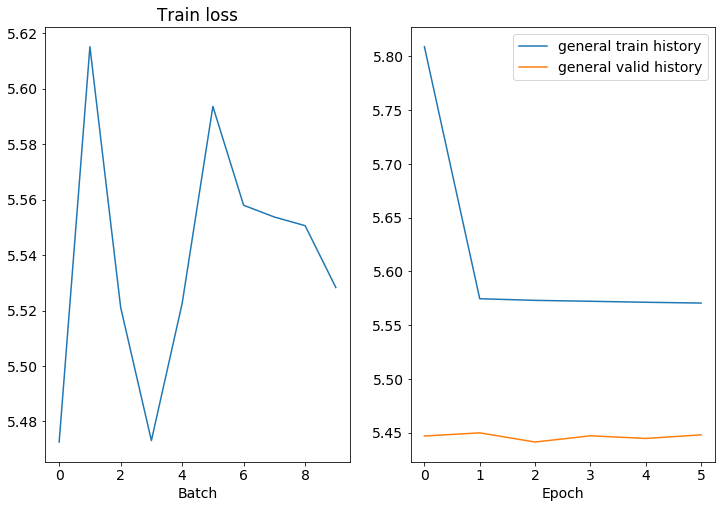

Имплементацию этих двух подходов вы можете найти в дополнительных файлах с префиксом `addition`.